In [1]:
# Setup and Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from train import train
from model_test import *
from atk import ATTACK_CONFIGS
import torch.optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from model import *
import os
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Training configurations
configs = [
    {'name': 'NonSpiking_WideResNet16_Clean', 'use_spike': False, 'atk': 'none', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'NonSpiking_WideResNet16-GN', 'use_spike': False, 'atk': 'gn', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'NonSpiking_WideResNet16-PGD', 'use_spike': False, 'atk': 'pgd', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'Spiking_WideResNet16-Clean', 'use_spike': True, 'atk': 'none', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4},
    {'name': 'Spiking_WideResNet16-GN', 'use_spike': True, 'atk': 'gn', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4},
    {'name': 'Spiking_WideResNet16-PGD', 'use_spike': True, 'atk': 'pgd', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4}
]

In [4]:
# Training Phase

In [5]:
# Train models with updated parameters
training_results = {}

for config in configs:
    print(f"\nTraining {config['name']}...")
    
    # Extract training parameters with defaults
    model_type = config.get('model_type', 'standard')
    use_spike = config.get('use_spike', False)
    print(use_spike)
    atk = config.get('atk', 'none')
    epochs = 2 # config.get('epochs', 10)
    batch_size = config.get('batch_size', 64)
    lr = 0.001#config.get('lr', 0.1)
    T = config.get('T', 4)
    optimizer = 'adamw'
    
    # Train model with optimized parameters
    result = train(
        #model_type=model_type,
        use_spike=use_spike,
        atk=atk,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        T=T,
        optimizer_type=optimizer
    )
    
    # Store results
    training_results[config['name']] = result
    print(f"Training completed for {config['name']}")
    print(f"Final test accuracy: {result['best_acc']:.2f}%")
    print(f"Model saved to: ./weight/{model_type}_spike_{use_spike}_atk_{atk}.pth")


Training NonSpiking_WideResNet16_Clean...
False
Training on 6000 samples, testing on 1000 samples
Attack type: none, Optimizer: adamw
Using standard WideResNet16
Epoch [1/2], Train Loss: 0.5370, Train Acc: 85.82%, Test Acc: 83.20%
New best model saved with accuracy: 83.20%
Epoch [2/2], Train Loss: 0.1095, Train Acc: 96.78%, Test Acc: 77.60%
Training completed for standard_spike_False_atk_none_adamw.pth
Final test accuracy: 83.20%
Model saved to: ./weight/standard_spike_False_atk_none_adamw.pth
Training completed for NonSpiking_WideResNet16_Clean
Final test accuracy: 83.20%
Model saved to: ./weight/standard_spike_False_atk_none.pth

Training NonSpiking_WideResNet16-GN...
False
Training on 6000 samples, testing on 1000 samples
Attack type: gn, Optimizer: adamw
Using standard WideResNet16
Epoch [1/2], Train Loss: 0.5820, Train Acc: 84.27%, Test Acc: 70.30%
New best model saved with accuracy: 70.30%
Epoch [2/2], Train Loss: 0.1142, Train Acc: 96.70%, Test Acc: 92.40%
New best model saved 

In [6]:
# Training Results Visualization

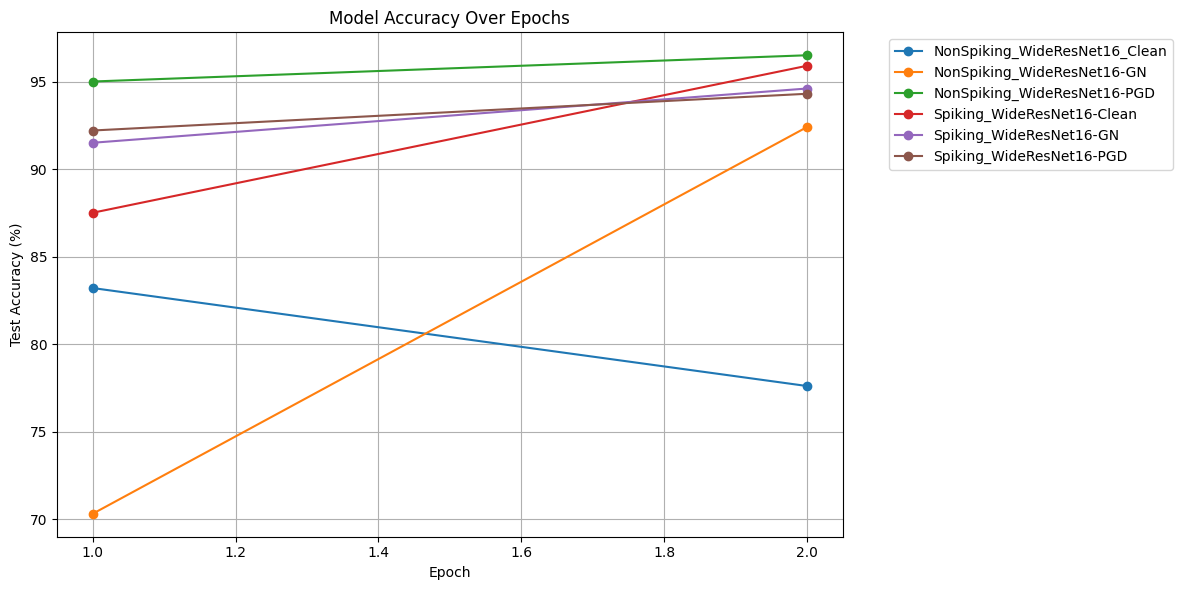

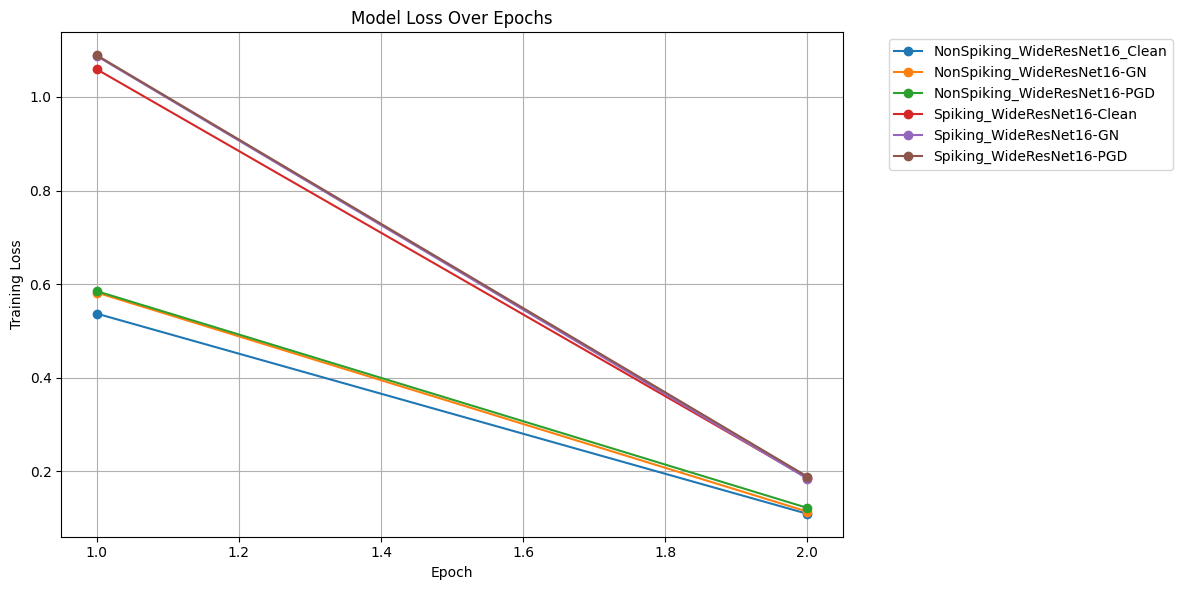

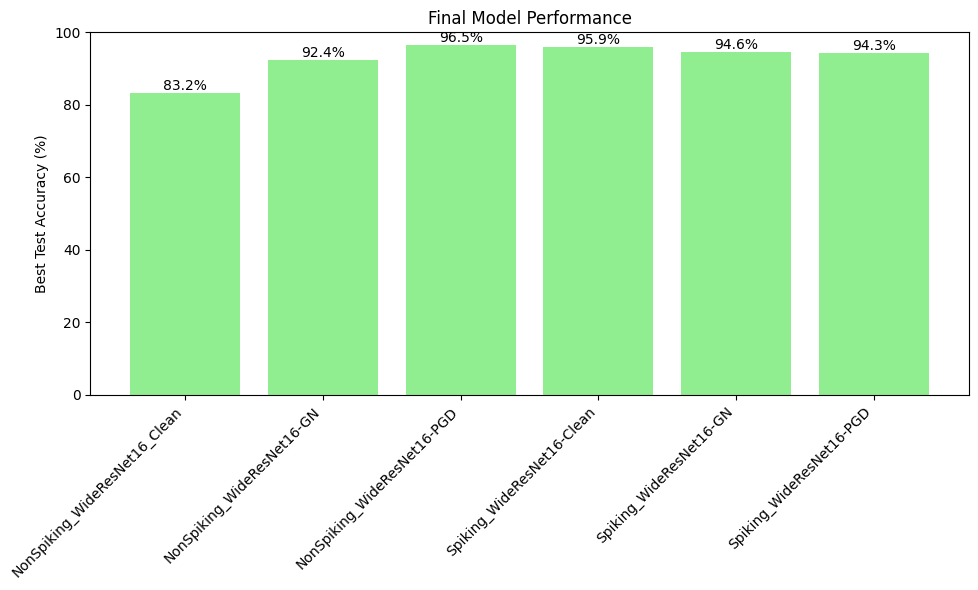


=== FINAL METRICS ===
Model Name                     Final Accuracy  Final Loss     
------------------------------------------------------------
NonSpiking_WideResNet16_Clean  77.60           0.1095         
NonSpiking_WideResNet16-GN     92.40           0.1142         
NonSpiking_WideResNet16-PGD    96.50           0.1221         
Spiking_WideResNet16-Clean     95.90           0.1863         
Spiking_WideResNet16-GN        94.60           0.1847         
Spiking_WideResNet16-PGD       94.30           0.1890         


In [7]:
def plot_training_progress(training_results):
    """
    Creates separate plots for accuracy and loss over epochs for each model
    """
    # Create figure for accuracy
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy for each model
    for model_name, result in training_results.items():
        accuracies = result['test_accuracies']
        epochs = range(1, len(accuracies) + 1)
        plt.plot(epochs, accuracies, marker='o', label=model_name)
    
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Model Accuracy Over Epochs')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Create figure for loss
    plt.figure(figsize=(12, 6))
    
    # Plot loss for each model
    for model_name, result in training_results.items():
        losses = result['train_losses']
        epochs = range(1, len(losses) + 1)
        plt.plot(epochs, losses, marker='o', label=model_name)
    
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Model Loss Over Epochs')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Create figure for final accuracies
    plt.figure(figsize=(10, 6))
    model_names = list(training_results.keys())
    final_accuracies = [result['best_acc'] for result in training_results.values()]
    
    # Create bar chart with color coding
    colors = ['lightblue' if 'spike' in name.lower() else 'lightgreen' for name in model_names]
    bars = plt.bar(range(len(model_names)), final_accuracies, color=colors)
    
    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
    plt.ylim([0, 100])
    plt.ylabel('Best Test Accuracy (%)')
    plt.title('Final Model Performance')
    plt.tight_layout()
    plt.show()
    
    # Print final metrics for each model
    print("\n=== FINAL METRICS ===")
    print(f"{'Model Name':<30} {'Final Accuracy':<15} {'Final Loss':<15}")
    print("-" * 60)
    for model_name, result in training_results.items():
        final_acc = result['test_accuracies'][-1]
        final_loss = result['train_losses'][-1]
        print(f"{model_name:<30} {final_acc:<15.2f} {final_loss:<15.4f}")

# Call the plotting function after training
plot_training_progress(training_results)

In [8]:
for config_name, result in training_results.items():
    print(config_name, result)

NonSpiking_WideResNet16_Clean {'best_acc': 83.2, 'train_losses': [0.5370134725136325, 0.10946658608364931], 'train_accuracies': [85.81666666666666, 96.78333333333333], 'test_accuracies': [83.2, 77.6]}
NonSpiking_WideResNet16-GN {'best_acc': 92.4, 'train_losses': [0.582020851763639, 0.11420203249980794], 'train_accuracies': [84.26666666666667, 96.7], 'test_accuracies': [70.3, 92.4]}
NonSpiking_WideResNet16-PGD {'best_acc': 96.5, 'train_losses': [0.5850156692669113, 0.1220684460304836], 'train_accuracies': [83.95, 96.66666666666667], 'test_accuracies': [95.0, 96.5]}
Spiking_WideResNet16-Clean {'best_acc': 95.9, 'train_losses': [1.0588537724094187, 0.18633928217310855], 'train_accuracies': [69.1, 95.45], 'test_accuracies': [87.5, 95.9]}
Spiking_WideResNet16-GN {'best_acc': 94.6, 'train_losses': [1.087175192033991, 0.1846958431316183], 'train_accuracies': [67.68333333333334, 95.48333333333333], 'test_accuracies': [91.5, 94.6]}
Spiking_WideResNet16-PGD {'best_acc': 94.3, 'train_losses': [1.

In [11]:
# Test models with different attacks
test_results = {}

# List of attack types to test
attack_types = ['none', 'gn', 'pgd']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Increase batch size for testing
test_batch_size = 256  # Increased from 64

for config_name, result in training_results.items():
    # Determine model type from config name
    use_spike = 'NonSpiking' not in config_name
    
    # Extract attack type from config name
    if '-GN' in config_name:
        train_attack = 'gn'
    elif '-PGD' in config_name:
        train_attack = 'pgd'
    else:
        train_attack = 'none'  # Default to 'none' for models trained on clean data
    
    optimizer = 'adamw'
    
    model_path = f"./weight/standard_spike_{use_spike}_atk_{train_attack}_{optimizer}.pth"
    print(f"\nTesting {model_path}...")
    
    # Load model once for all attacks
    model = get_model(use_spike=use_spike)
    
    try:
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        model.eval()
        
        # Dictionary to store accuracies for this model
        model_results = {}
        
        # Test with different attacks
        for attack in attack_types:
            print(f"  Testing with {attack} attack...")
            acc, class_accs, conf_matrix = test(  # Unpack all three values
                model=model,
                attack_type=attack,
                batch_size=test_batch_size,
                device=device,
                optimizer=optimizer
            )
            
            model_results[attack] = {
                'accuracy': acc,
                'class_accuracies': class_accs,
                'confusion_matrix': conf_matrix  # Add confusion matrix to results
            }
            
            print(f"    Accuracy: {acc:.2f}%")
        
        test_results[config_name] = model_results
    except Exception as e:
        print(f"Error testing {config_name}: {e}")
        test_results[config_name] = {'error': str(e)}


Testing ./weight/standard_spike_False_atk_pgd_adamw.pth...
Using standard WideResNet16
  Testing with none attack...
In test function, attack_type: none, optimizer: adamw
Model is non-spiking
    Accuracy: 24.30%
  Testing with gn attack...
In test function, attack_type: gn, optimizer: adamw
Model is non-spiking
    Accuracy: 97.60%
  Testing with pgd attack...
In test function, attack_type: pgd, optimizer: adamw
Model is non-spiking
    Accuracy: 95.80%

Testing ./weight/standard_spike_False_atk_pgd_adamw.pth...
Using standard WideResNet16
  Testing with none attack...
In test function, attack_type: none, optimizer: adamw
Model is non-spiking
    Accuracy: 23.60%
  Testing with gn attack...
In test function, attack_type: gn, optimizer: adamw
Model is non-spiking
    Accuracy: 96.20%
  Testing with pgd attack...
In test function, attack_type: pgd, optimizer: adamw
Model is non-spiking
    Accuracy: 95.10%

Testing ./weight/standard_spike_False_atk_pgd_adamw.pth...
Using standard WideR

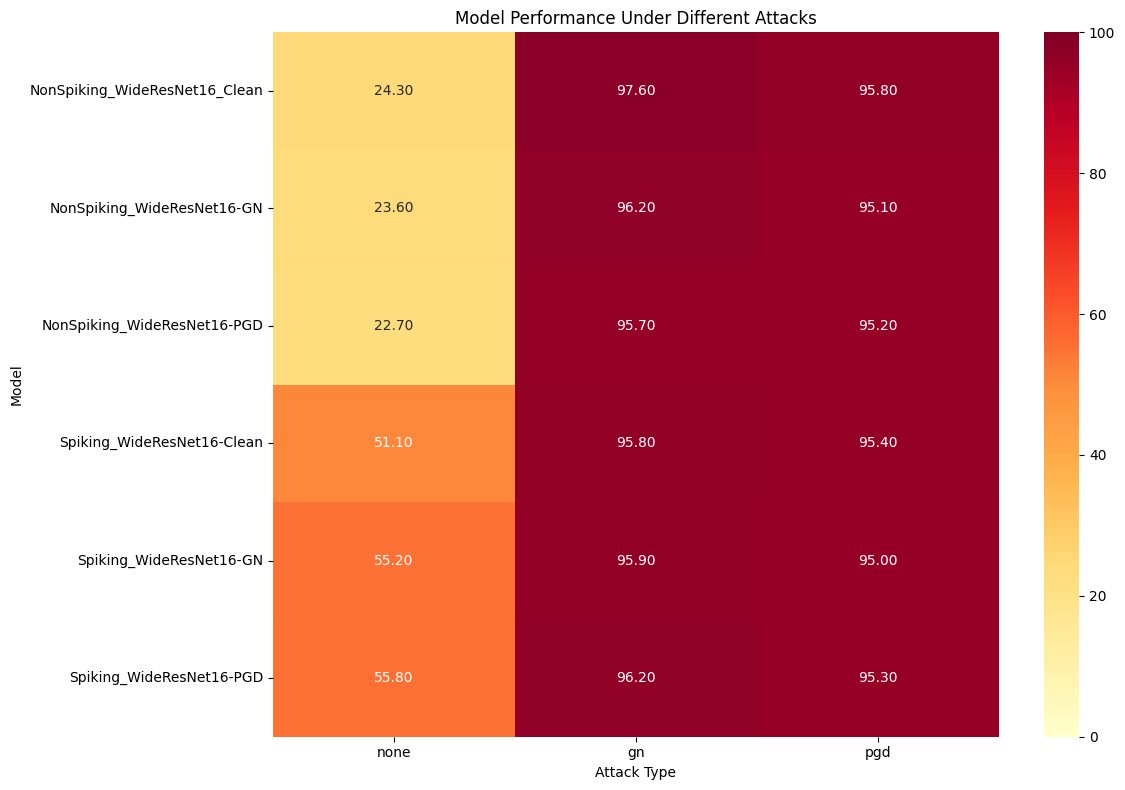

In [12]:
# Get model names and attack types
model_names = list(test_results.keys())
attack_names = ['none', 'gn', 'pgd']  # Make sure these match your attack types

if not model_names:
    print("No models were successfully tested. Please check the debug output above.")
else:
    # Initialize the comparison matrix with NaN values
    comparison_matrix = np.full((len(model_names), len(attack_names)), np.nan)
    
    # Fill the matrix with accuracies
    for i, model_name in enumerate(model_names):
        for j, attack_name in enumerate(attack_names):
            if attack_name in test_results[model_name]:
                comparison_matrix[i, j] = test_results[model_name][attack_name]['accuracy']
    
    # Check if we have any valid values
    if np.isnan(comparison_matrix).all():
        print("No valid accuracy values found in the results.")
    else:
        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(comparison_matrix, 
                    annot=True, 
                    fmt='.2f',
                    xticklabels=attack_names,
                    yticklabels=model_names,
                    cmap='YlOrRd',
                    vmin=0,  # Set minimum value to 0
                    vmax=100)  # Set maximum value to 100 for accuracy percentage

        plt.title('Model Performance Under Different Attacks')
        plt.xlabel('Attack Type')
        plt.ylabel('Model')
        plt.tight_layout()
        plt.show()

In [13]:
# Per-Class Analysis
test_results

{'NonSpiking_WideResNet16_Clean': {'none': {'accuracy': 24.3,
   'class_accuracies': [0.0,
    0.0,
    1.2345679012345678,
    0.0,
    0.0,
    28.0,
    32.11009174311926,
    0.0,
    100.0,
    70.6896551724138],
   'confusion_matrix': array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 104.,   1.],
          [  0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,  98.,   0.],
          [  0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,  73.,   6.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 103.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  56.,  32.],
          [  0.,   0.,   0.,   0.,   0.,  21.,   1.,   0.,  52.,   1.],
          [  0.,   0.,   0.,   0.,   0.,   0.,  35.,   0.,  74.,   0.],
          [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,  70.,  48.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 104.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  34.,  82.]],
         dtype=float32)},
  'gn': {'accur

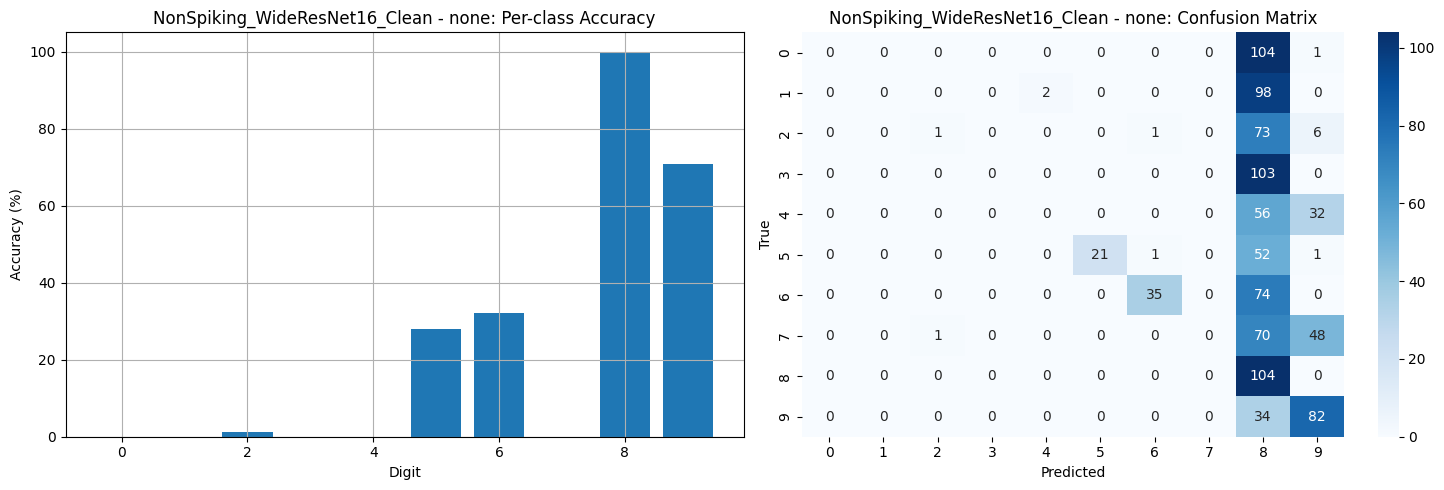

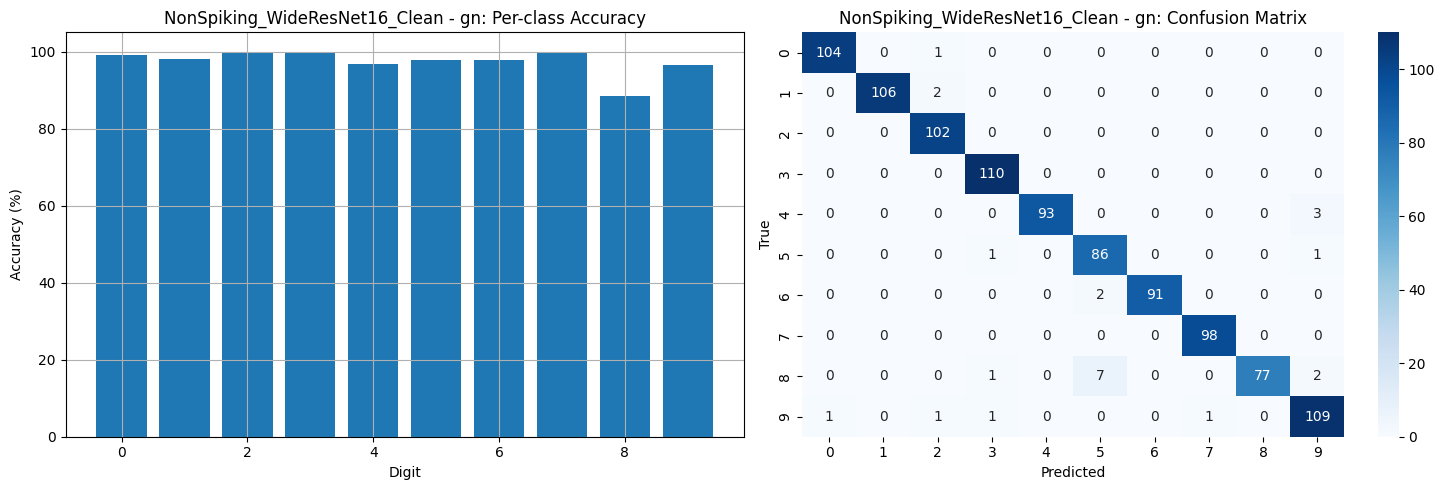

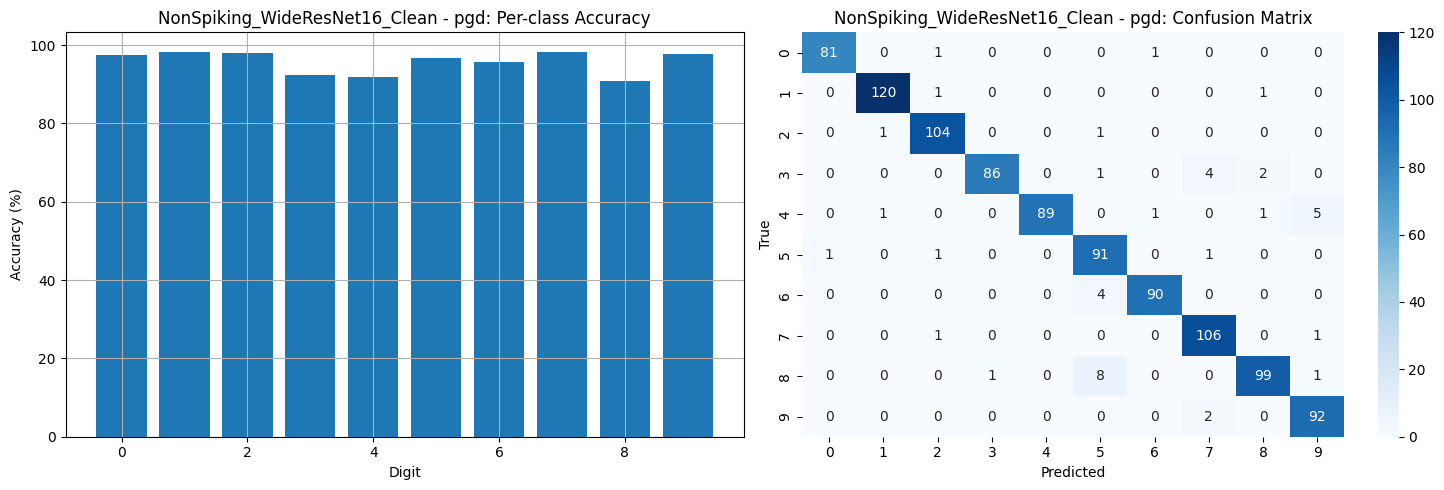

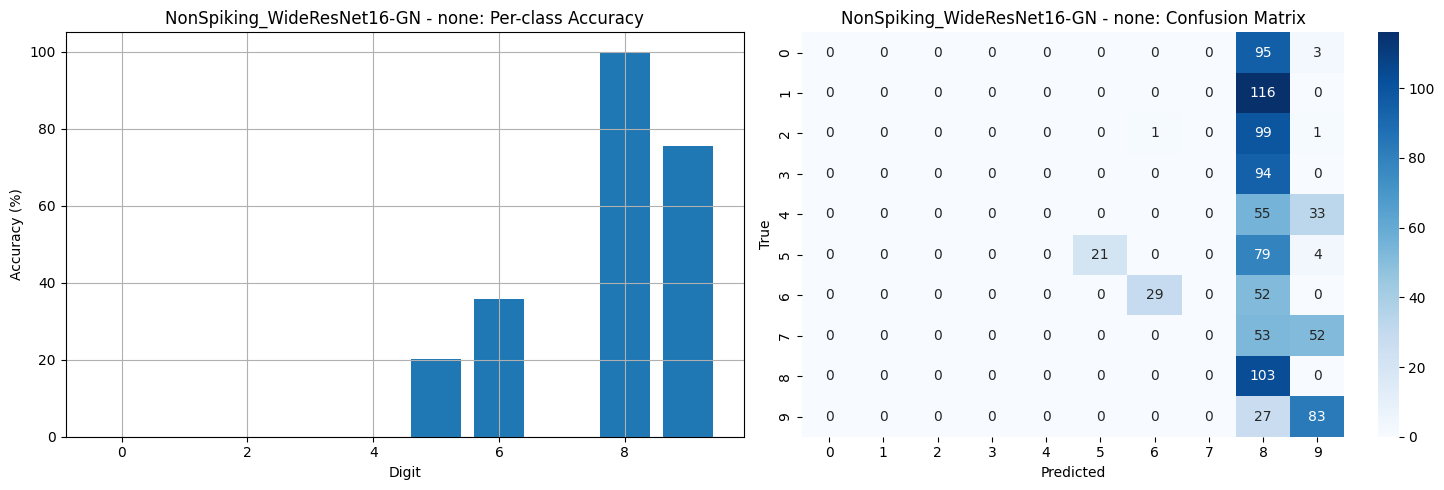

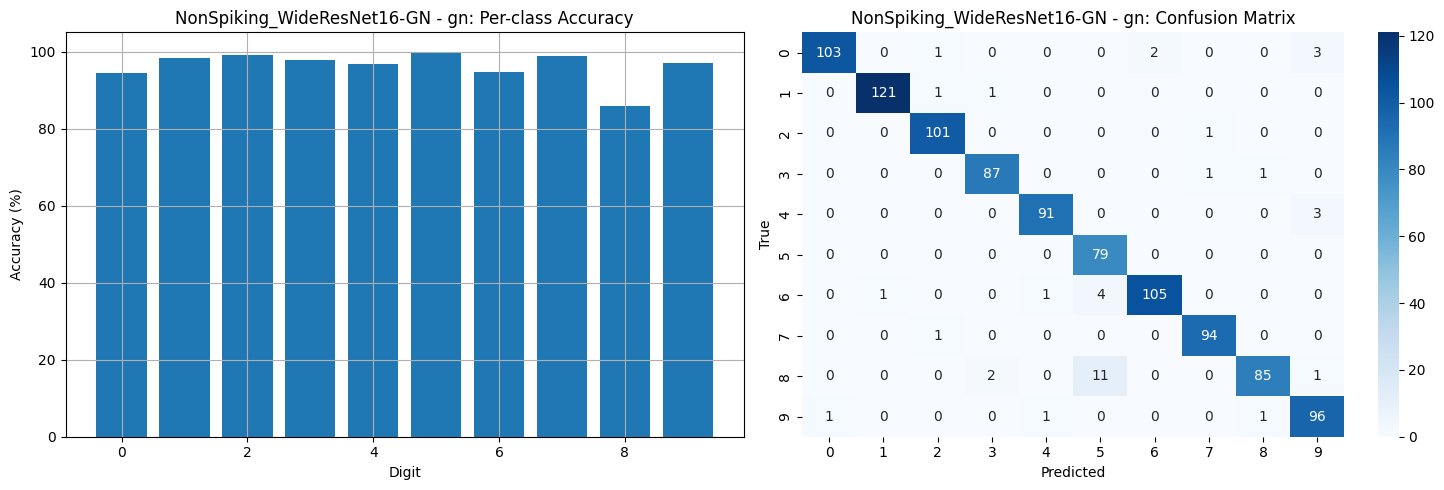

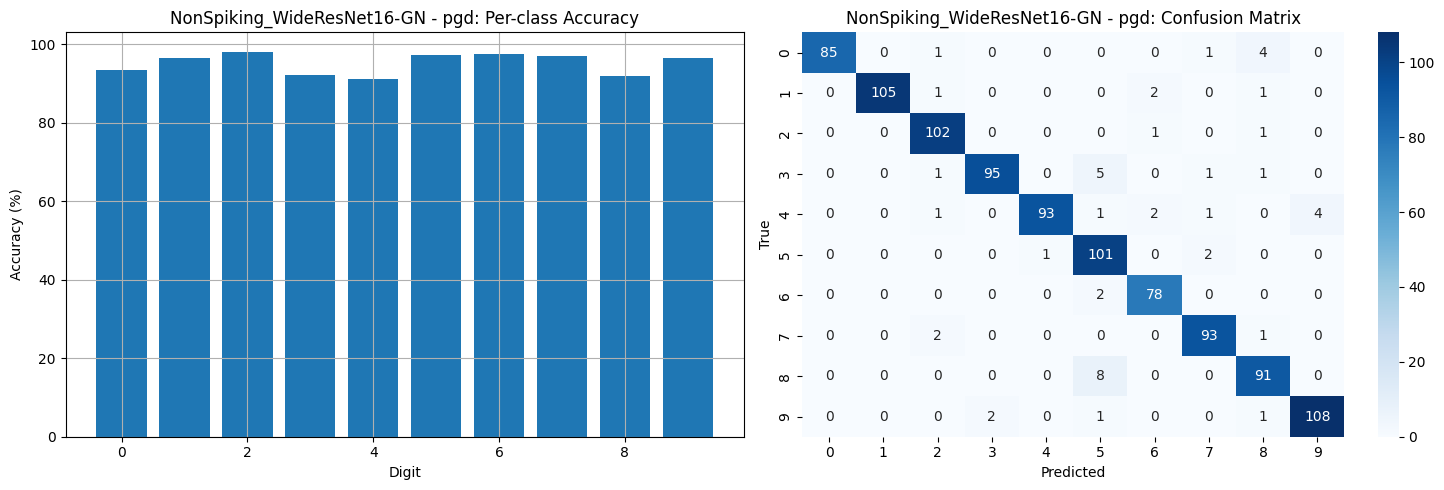

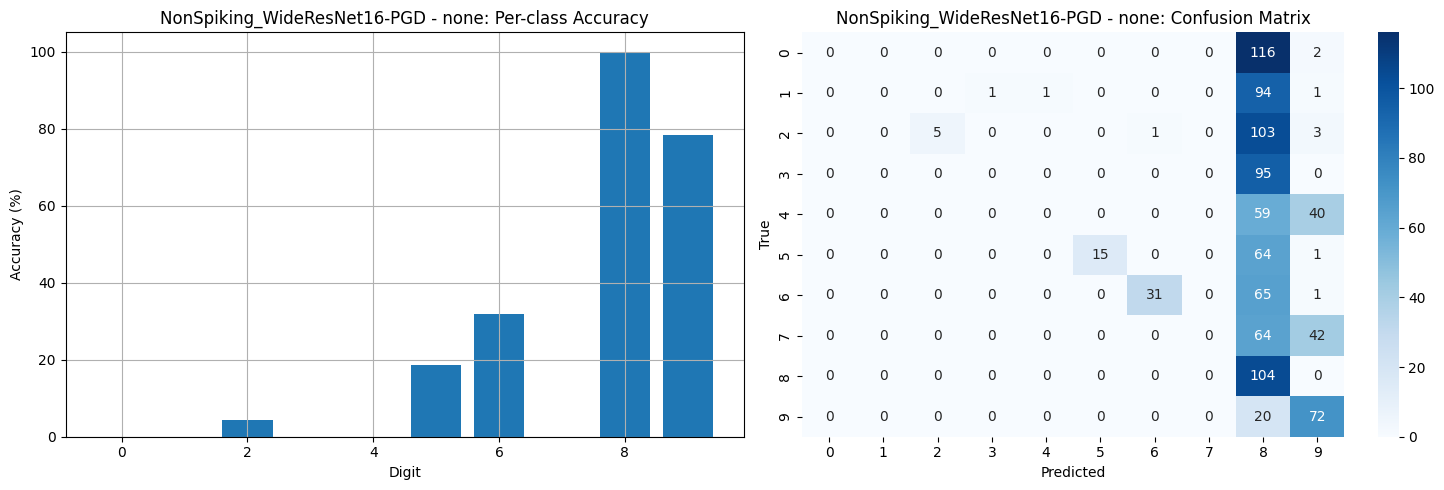

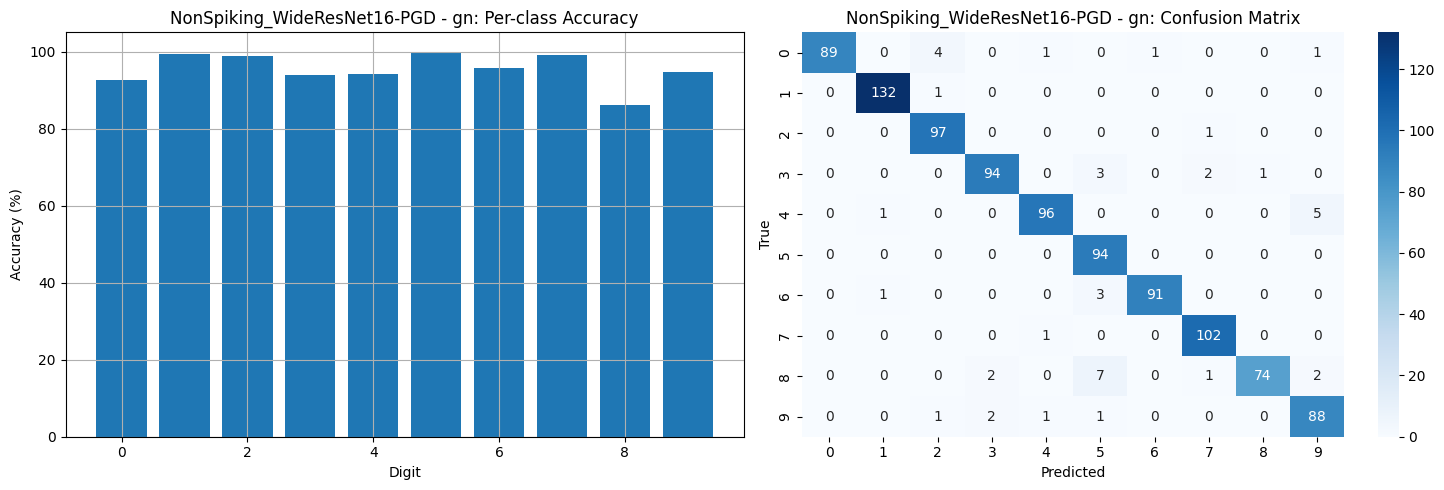

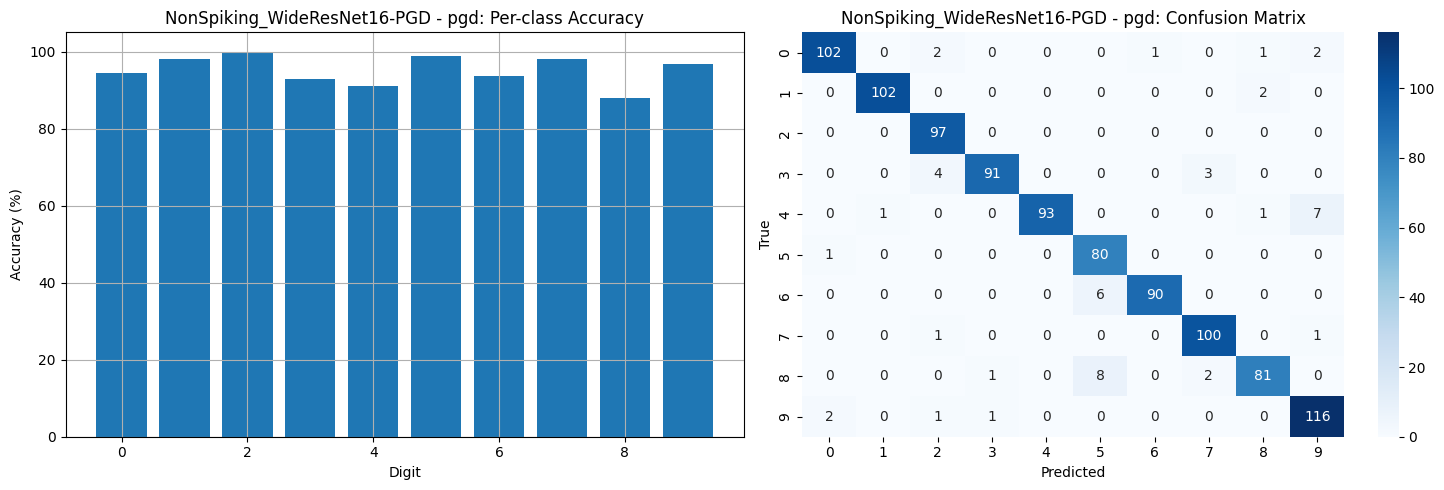

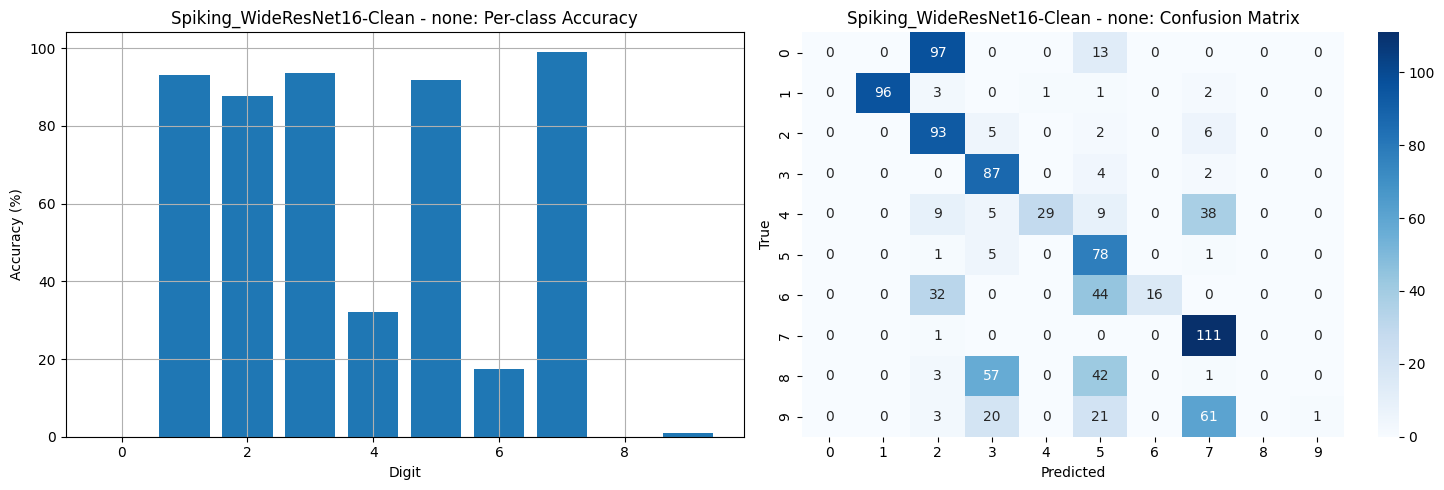

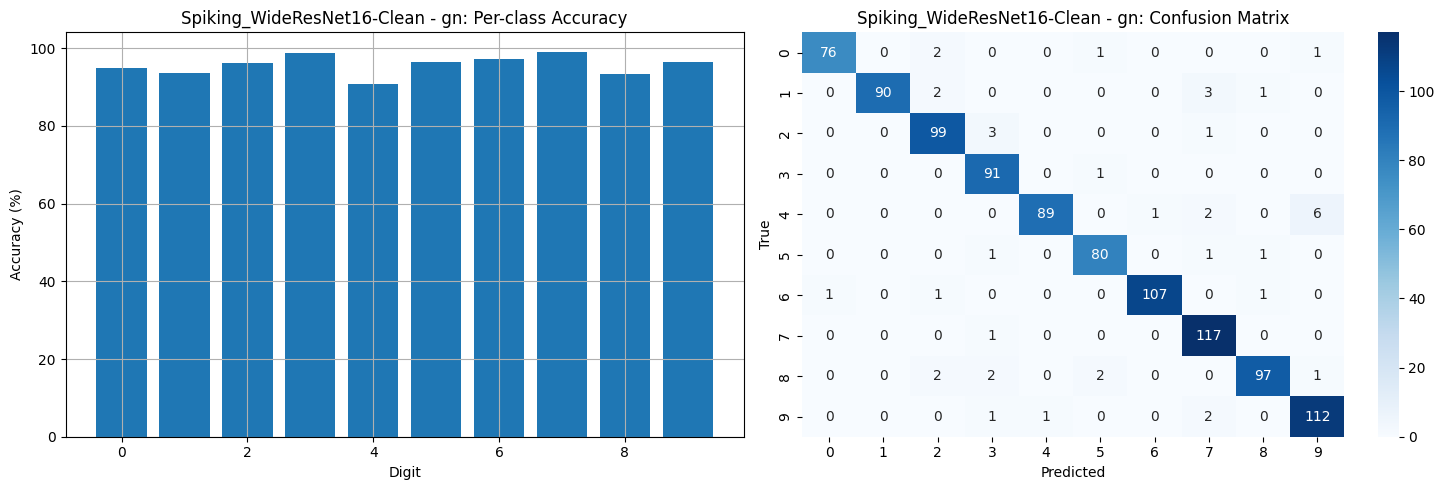

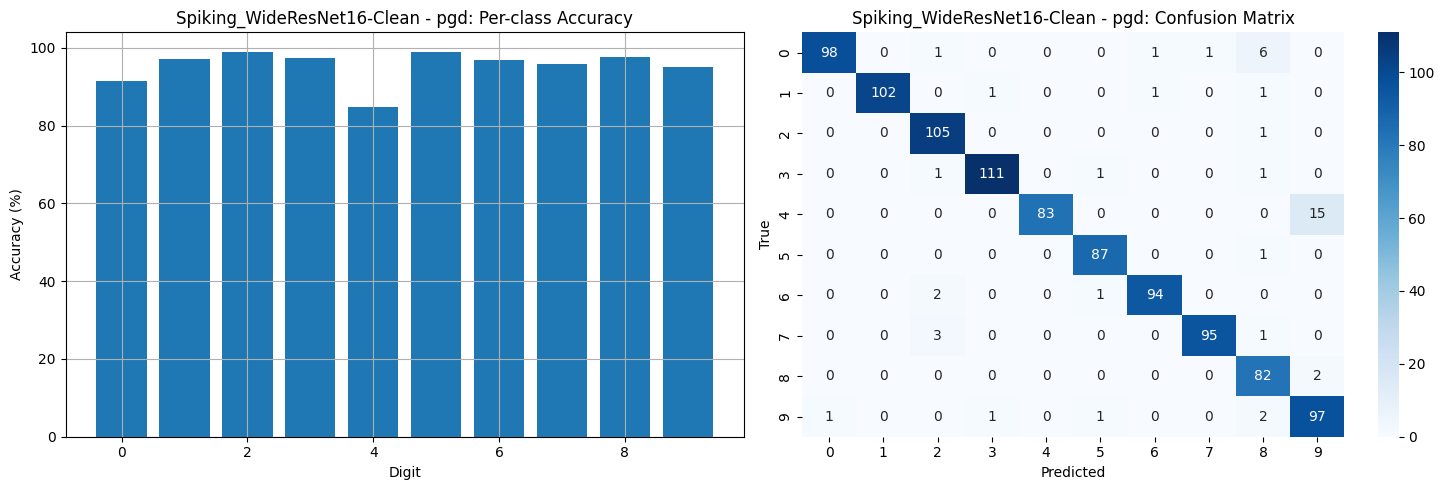

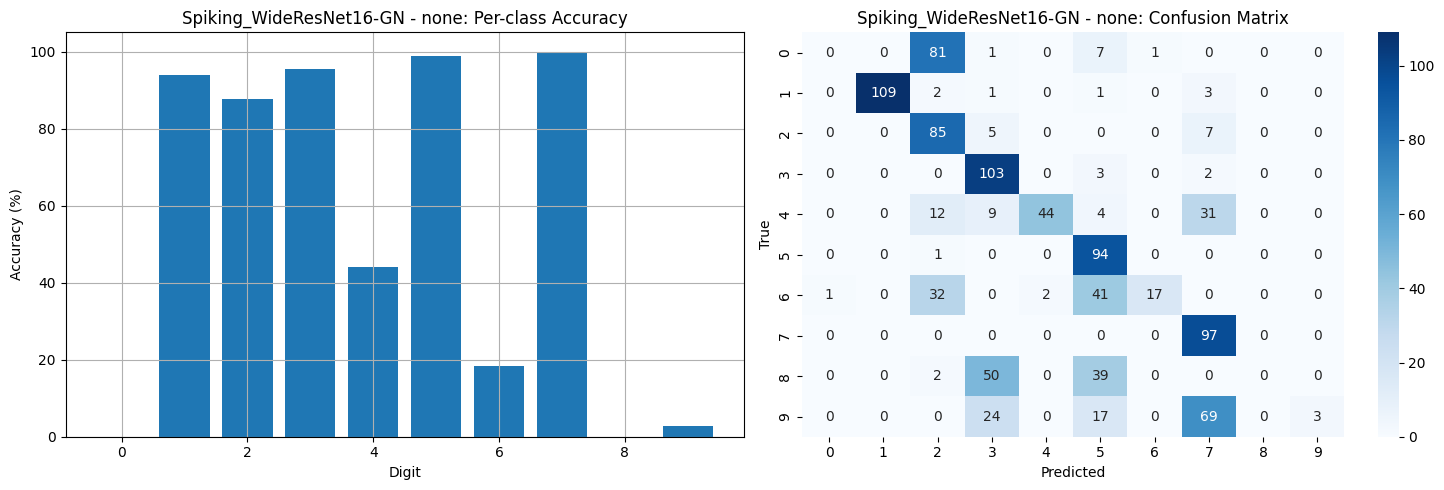

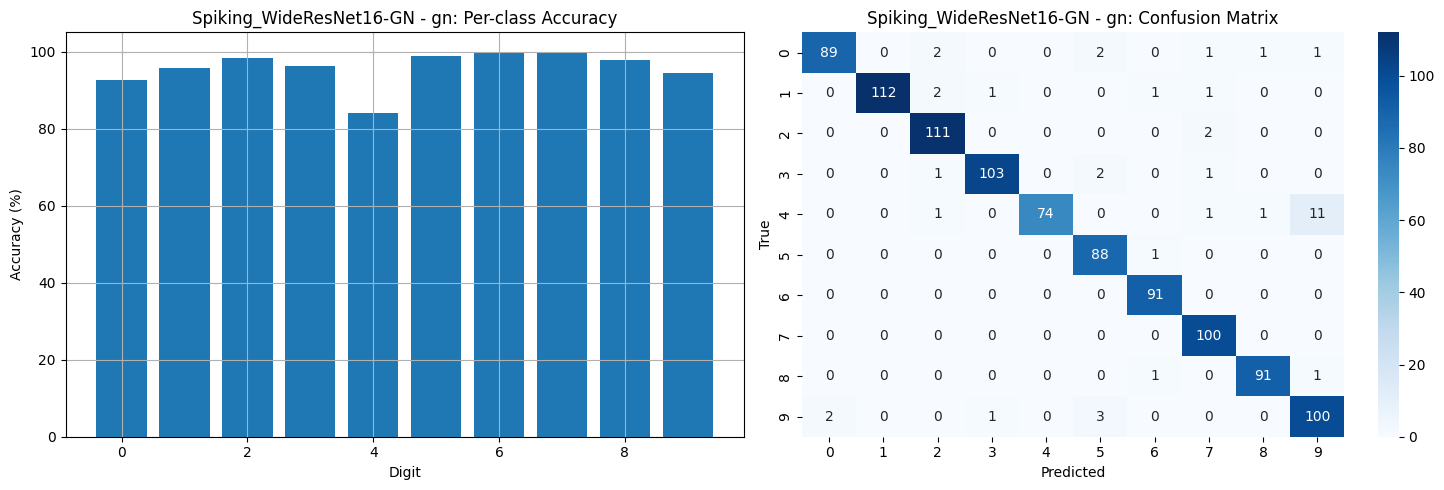

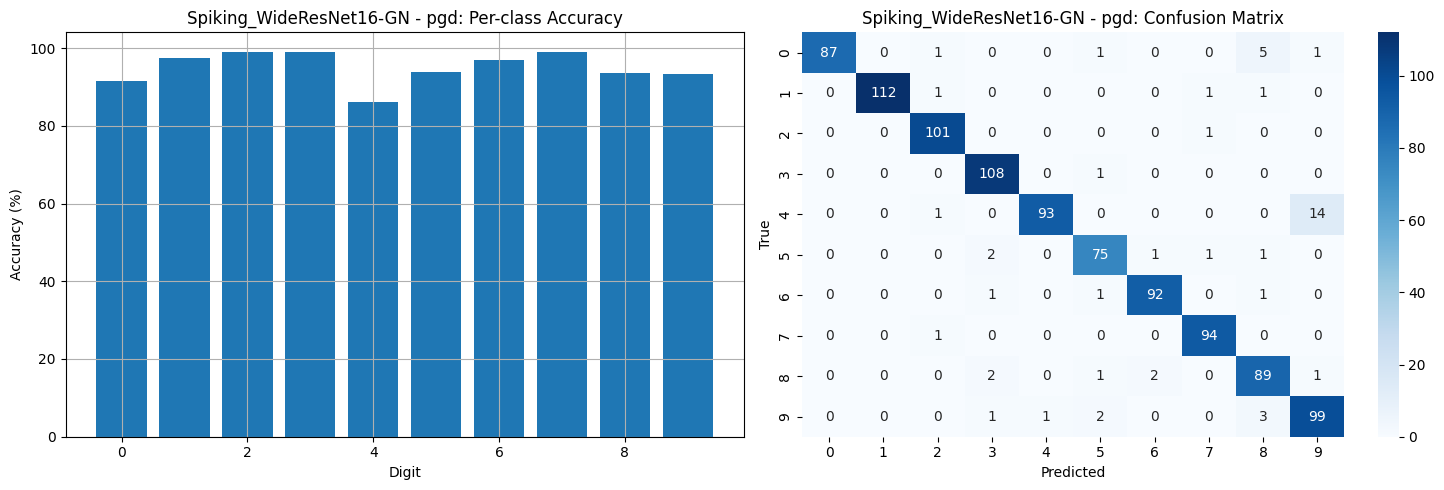

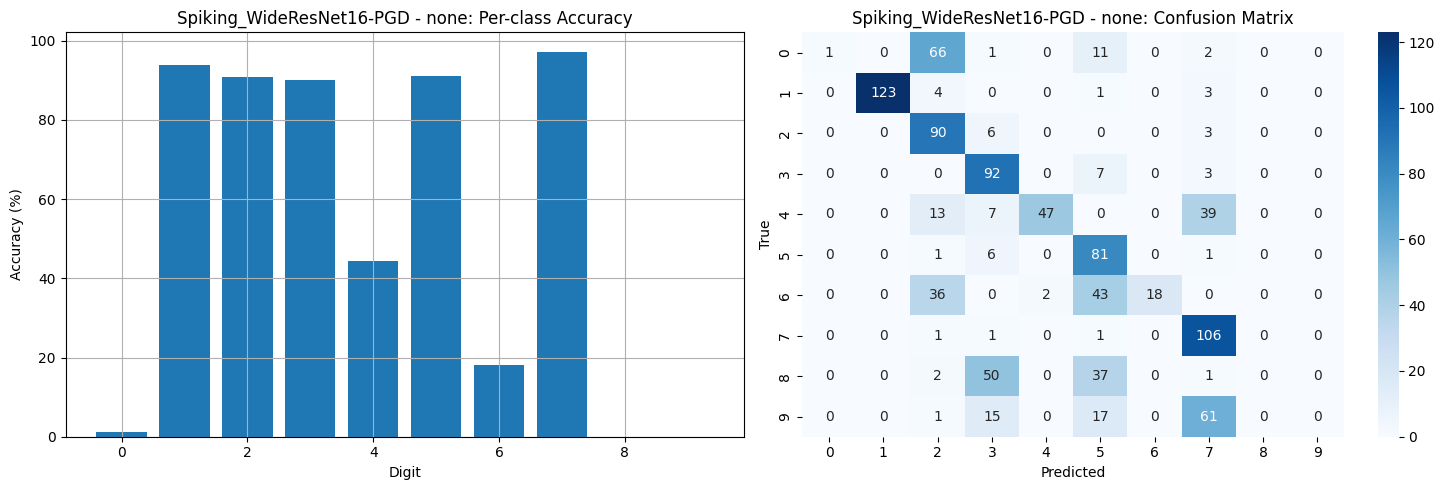

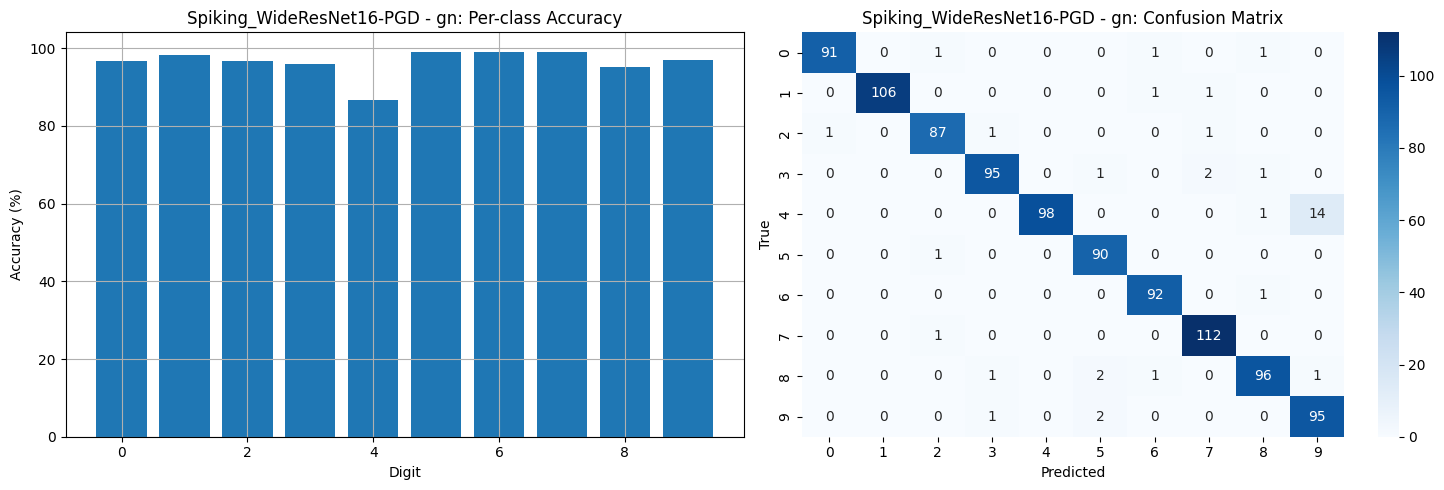

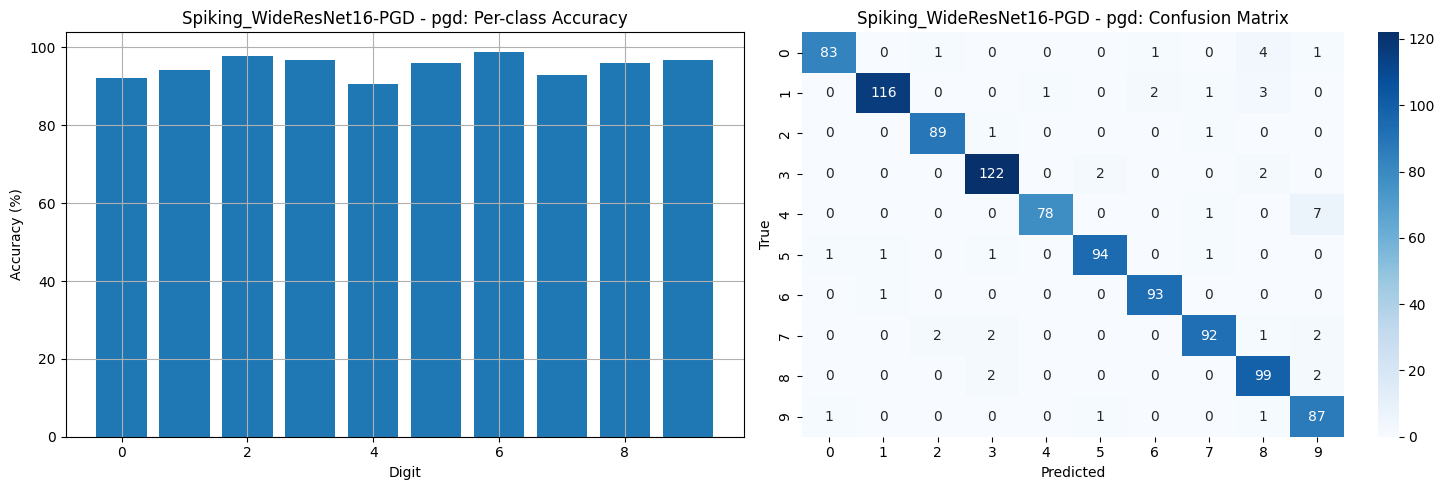

In [14]:
for config in configs:
    model_name = config['name']
    if model_name not in test_results:
        print(f"Warning: Model {model_name} not found in test results")
        continue
        
    for attack_name in ['none', 'gn', 'pgd']:
        if attack_name not in test_results[model_name]:
            print(f"Warning: Attack {attack_name} not found for model {model_name}")
            continue
            
        plt.figure(figsize=(15, 5))
        
        # Per-class accuracy bar plot
        plt.subplot(1, 2, 1)
        class_acc = test_results[model_name][attack_name]['class_accuracies']
        plt.bar(range(10), class_acc)
        plt.xlabel('Digit')
        plt.ylabel('Accuracy (%)')
        plt.title(f'{model_name} - {attack_name}: Per-class Accuracy')
        plt.grid(True)
        
        # Confusion matrix
        plt.subplot(1, 2, 2)
        conf_matrix = test_results[model_name][attack_name]['confusion_matrix']
        # Use '.0f' format for floats that should be displayed as integers
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{model_name} - {attack_name}: Confusion Matrix')
        
        plt.tight_layout()
        plt.show()

In [15]:
# Attack Effectiveness Comparison

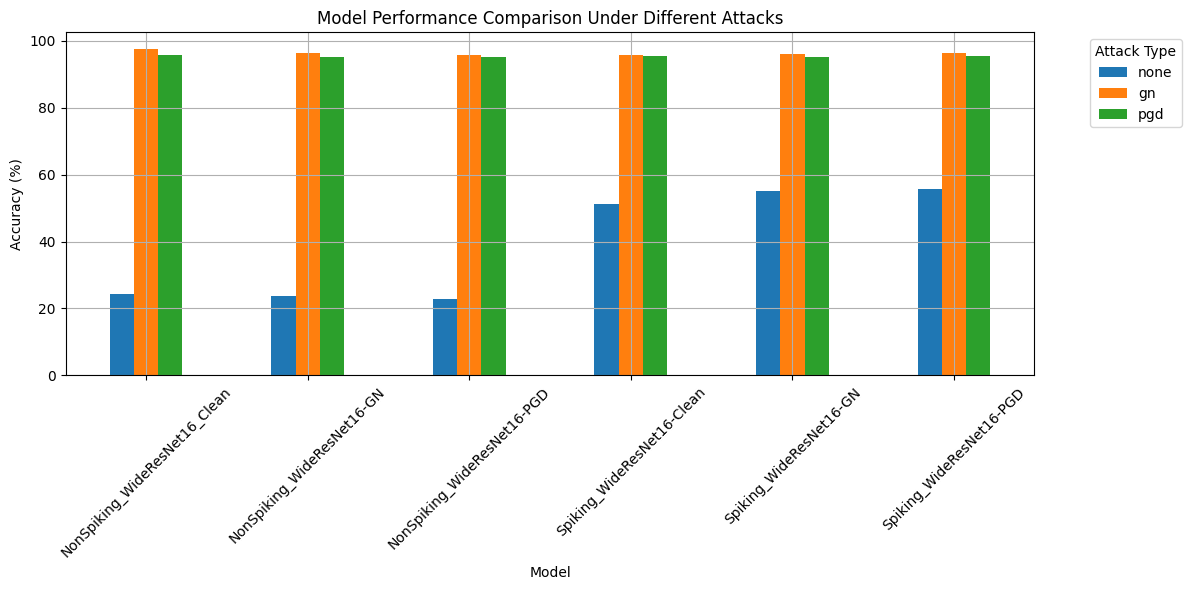

In [16]:
plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.15
multiplier = 0

for attack_name in attack_names:
    attack_accuracies = [test_results[model_name][attack_name]['accuracy'] 
                       for model_name in model_names]
    offset = width * multiplier
    plt.bar(x + offset, attack_accuracies, width, label=attack_name)
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison Under Different Attacks')
plt.xticks(x + width * (len(attack_names)-1)/2, model_names, rotation=45)
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Summary Statistics

In [18]:
# Map your preferred display names to the actual keys in test_results
attack_name_mapping = {
    'Clean': 'none',
    'GN (weak)': 'gn',
    'PGD (strong)': 'pgd'
}

print("\nSummary Statistics:")
print("-" * 80)
# Update this header to match your preferred names
print(f"{'Model':<30} {'Clean':>10} {'GN (weak)':>10} {'PGD (strong)':>10}")
print("-" * 80)

for model_name in model_names:
    stats = []
    try:
        # Use the mapping to get the correct keys
        stats = [
            test_results[model_name][attack_name_mapping['Clean']]['accuracy'],
            test_results[model_name][attack_name_mapping['GN (weak)']]['accuracy'],
            test_results[model_name][attack_name_mapping['PGD (strong)']]['accuracy']
        ]
        
        print(f"{model_name:<30}", end="")
        for stat in stats:
            print(f"{stat:>10.2f}", end="")
        print()
    except KeyError as e:
        print(f"{model_name:<30} Error: Missing key {e}")


Summary Statistics:
--------------------------------------------------------------------------------
Model                               Clean  GN (weak) PGD (strong)
--------------------------------------------------------------------------------
NonSpiking_WideResNet16_Clean      24.30     97.60     95.80
NonSpiking_WideResNet16-GN         23.60     96.20     95.10
NonSpiking_WideResNet16-PGD        22.70     95.70     95.20
Spiking_WideResNet16-Clean         51.10     95.80     95.40
Spiking_WideResNet16-GN            55.20     95.90     95.00
Spiking_WideResNet16-PGD           55.80     96.20     95.30
